# Turoial: RDL-SIM traning with DFCAN 
In this notebbok, train a RDL-SIM pipeline with prior knowledge of morier Pattern. 
- load the data
- define parameters specific to dataset and microscope. 
- define and load the DFCAN module (SIM reconstion module)
- define RDl-SIM model 
- train
- Visualize

In [ ]:
import datetime
from csbdeep.io import load_training_data
from csbdeep.utils import axes_dict, plot_some, plot_history
import matplotlib.pyplot as plt
# from models_varun_new import Denoiser, Train_RDL_Denoising
from rdl_denoising.models_clean import Denoiser, Train_RDL_Denoising
from rdl_denoising.loss_functions import mse_ssim, mse_ssim_psnr 
import tensorflow as tf
import os
from pathlib import Path
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.callbacks import TensorBoard
from wandb.integration.keras import WandbMetricsLogger, WandbEvalCallback
import numpy as np
from csbdeep.utils import normalize
# from tensorflow.image import psnr, ssim
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import normalized_root_mse as sklearn_nrmse
import tifffile
######  login WANDB #########
import wandb
from rdl_denoising.model_DFCAN import DFCAN
import psutil

In [2]:
# pip install git+https://github.com/ArghaSarker/RDL_denoising.git

In [3]:
root_dir = '../dataset/microtubules'

den_model_dir = '../dataset/microtubules/tuturial_models/DN' # now trained for 02 as well
Path(den_model_dir).mkdir(exist_ok=True, parents=True)
sr_model_dir = "../trained_models/microtubules/DFCAN_complete"# now trained for 02 as well

print("den_model_dir exists:", Path(den_model_dir).exists())
# print("sr_model_dir exists:", Path(sr_model_dir).exists())

den_model_dir exists: True


In [4]:
val_data_file = f'../dataset/microtubules/val/Train/DN/microtubules_DN_trainig.npz'
train_data_file = f'../dataset/microtubules/train/Train/DN/microtubules_DN_trainig.npz'

log_dir = "logs/fitDN/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
output_dir =Path.cwd() / f'DN-Trainig_output'
output_dir.mkdir(parents=True, exist_ok=True)

    
(X,Y), _ , axes = load_training_data(train_data_file, verbose=True)
(X_val,Y_val), _ , axes = load_training_data(val_data_file, verbose=True)

number of training images:	 25
number of validation images:	 0
image size (2D):		 (128, 128)
axes:				 SYXC
channels in / out:		 9 / 9
number of training images:	 15
number of validation images:	 0
image size (2D):		 (128, 128)
axes:				 SYXC
channels in / out:		 9 / 9


In [5]:
print(X.shape, Y.shape)
print(X_val.shape, Y_val.shape)

(25, 128, 128, 9) (25, 128, 128, 9)
(15, 128, 128, 9) (15, 128, 128, 9)


### Visualization of the training data

Text(0.5, 0.98, '5 example validation patches \n(top row: Input, bottom row: Target)')

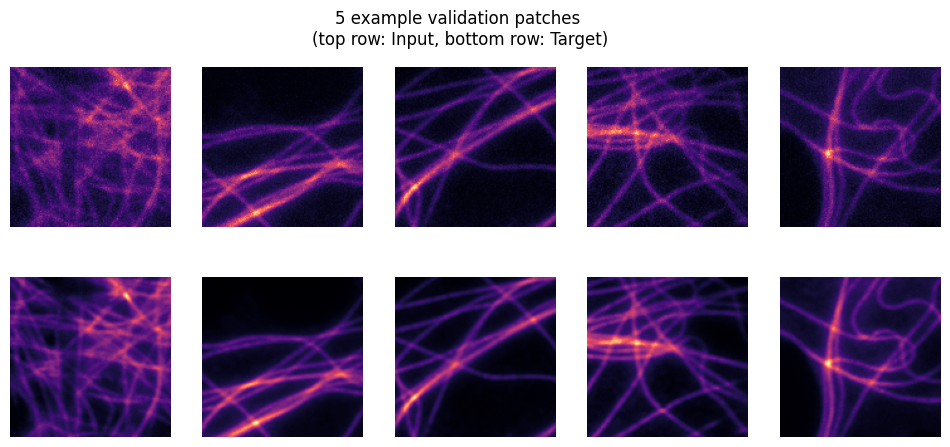

In [6]:
plt.figure(figsize=(12,5))
plot_some(tf.transpose(X_val[:5], perm=[0, 3, 1, 2]),tf.transpose(Y_val[:5], perm=[0, 3, 1, 2]))
plt.suptitle('5 example validation patches \n(top row: Input, bottom row: Target)')
# plt.savefig(f'{output_dir}/DN_train_image_F-actin_04_big.png', bbox_inches='tight')

### Define paramertes

In [ ]:
data = (X, Y)
data_val = (X_val, Y_val)

init_lr = 1e-4
lr_decay_factor =.67	# Learning rate decay factor	

batch_size = 4
epochs = 5
beta_1=0.9
beta_2=0.999
wavelength = 0.488
# wavelength = 488 
excNA = 1.35
# excNA = 1.3 # uni data
# dx = 80.8e-3 # change here
dx = 62.6e-3
dy = dx
# dx = 80.8e-3 # uni data
# dy = 80.8e-3 # uni data


dxy = dx 
scale_gt = 2.0
setupNUM = 0
space = wavelength/excNA/2 # here is teh change = /2
k0mod = 1 / space
napodize = 10
nphases = 3
ndirs = 3
sigma_x = 0.5
sigma_y = 0.5
recalcarrays = 2
ifshowmodamp = 0
otf_path = '../dataset/TIRF488_cam1_0_z30_OTF2d.mrc' # the otf from the RDL-Sim package
norders = int((nphases + 1) / 2)
if setupNUM == 0:
    k0angle_c = [1.48, 2.5272, 3.5744]
    k0angle_g = [0.0908, -0.9564, -2.0036]  
if setupNUM == 1:
    k0angle_c = [-1.66, -0.6128, 0.4344]
    k0angle_g = [3.2269, 2.1797, 1.1325]      
if setupNUM == 2:
    k0angle_c = [1.5708, 2.618, 3.6652]
    k0angle_g = [0, -1.0472, -2.0944] 

total_data,  height, width, channels = X.shape
print(f'\n\n total_data,  height, width, channels : {total_data,  height, width, channels} \n\n')
print('This are the startting parameters for the training')
print(f'init_lr : {init_lr} \nepochs : {epochs} \nbatch_size : {batch_size} \nbeta_1 : {beta_1} \nbeta_2 : {beta_2} \n')

# define parameter dictionary 
parameters = {
    'Ny': height,
    'Nx': width,
    'lr_decay_factor': lr_decay_factor,
    'wavelength':wavelength,
    'excNA':excNA,
    'ndirs':ndirs,
    'nphases':nphases,
    'init_lr': init_lr,
    'ifshowmodamp':ifshowmodamp,
    'batch_size': batch_size,
    'epochs': epochs,
    'beta_1':beta_1,
    'beta_2':beta_2,
    'scale_gt': scale_gt,
    'setupNUM': setupNUM,
    'k0angle_c':k0angle_c,
    'k0angle_g':k0angle_g,
    'recalcarrays':recalcarrays,
    'dxy':dxy,
    'space':space,
    'k0mod':k0mod,
    'norders':norders,
    'napodize':napodize,
    'scale': scale_gt,
    'sigma_x': sigma_x,
    'sigma_y': sigma_y,
    'log_dir': log_dir,
    'den_model_dir': den_model_dir,
    'sr_model_dir': sr_model_dir,
    'otf_path' : otf_path,
    'results_path': output_dir        
}





 total_data,  height, width, channels : (25, 128, 128, 9) 


This are the startting parameters for the training
init_lr : 0.0001 
epochs : 5 
batch_size : 4 
beta_1 : 0.9 
beta_2 : 0.999 



### Define and load the models 

In [ ]:


# check the SR model and load the model if it is already trained 
if len(os.listdir(sr_model_dir)) > 0:

    with tf.keras.utils.custom_object_scope({'mse_ssim': mse_ssim}):
        if len(os.listdir(sr_model_dir)) > 0:
            print(f'Loading model from {sr_model_dir}')

                    
            Trainingmodel_dfcan = DFCAN((height, width, channels), scale=2) # define the model with the sape of the image
            optimizer = Adam(learning_rate=init_lr, beta_1=beta_1, beta_2=beta_2)
            Trainingmodel_dfcan.load_weights(sr_model_dir)
            Trainingmodel_dfcan.compile(optimizer=optimizer, loss=mse_ssim)



            # Trainingmodel_dfcan = load_model(sr_model_dir)
else:
    print('Model not found, please train the SR model first')
    assert 'DFCAN model has to be trained before training RDL denosier'  

Trainingmodel_denoise = Denoiser((height, width, nphases))
optimizer = Adam(learning_rate=init_lr, beta_1=beta_1, beta_2=beta_2)
Trainingmodel_denoise.compile(loss=mse_ssim, optimizer=optimizer)


# define the DN model and compile the model 
if len(os.listdir(den_model_dir)) > 0:
    with tf.keras.utils.custom_object_scope({'mse_ssim': mse_ssim}):
        if len(os.listdir(den_model_dir)) > 0:
            print(f'Loading model from {den_model_dir}')
            Trainingmodel_denoise = load_model(den_model_dir)
else:
    Trainingmodel_denoise = Denoiser((height, width, nphases))
    optimizer = Adam(learning_rate=init_lr, beta_1=beta_1, beta_2=beta_2)
    Trainingmodel_denoise.compile(loss=mse_ssim, optimizer=optimizer)

## Load the denoising model and Train the RDL denoiser
rdl_denoising = Train_RDL_Denoising(
                    srmodel=Trainingmodel_dfcan, 
                    denmodel=Trainingmodel_denoise,
                    loss_fn=mse_ssim,
                    optimizer=optimizer,
                    parameters = parameters,
                    verbose=False)



Loading model from ../trained_models/microtubules/DFCAN_complete
Information OTF how its read
(256, 256) float64 1.0 -0.0006461802372663593

Information PSF how its read
(256, 256) float64 0.011698316186498404 1.0611680661324662e-10

Information prol_OTF how its read
(366,) float64 1.0 -0.0006461802372663593


In [ ]:

# traing the model

rdl_denoising.fit(data= data, data_val = data_val)




Momery infromation before calling the fit function from teh main code 


this is teh data shape being feed into rdl_data_loader for training
1/1 [==============================] - 24s 24s/step
sr predcitec inside train (25, 256, 256)


before the bacth preprocessing startes on the training data


Processing batches for training data:   0%|          | 0/1 [00:00<?, ?it/s]


before each mini batch startes for training data pre processing



Processing batches for training data: 100%|██████████| 1/1 [00:06<00:00,  6.30s/it]


after each batch pre processing training data pre processing ---> Memory requirement



this are teh shapes that I want to work with
input_MPE_batch shape: (25, 128, 128, 9) 
input_PFE_batch shape: (25, 128, 128, 9) 
gt_batch shape: (25, 128, 128, 9) 




1/1 [==============================] - 13s 13s/step


Processing batches for validation data: 100%|██████████| 1/1 [00:03<00:00,  3.76s/it]

model summary
model outputs
[<KerasTensor: shape=(None, 128, 128, 3) dtype=float32 (created by layer 'final_out')>]
model layerss and names
mfe_out output shape: (None, 128, 128, 64)
pfe_out output shape: (None, 128, 128, 64)

before actual training starts,  the status of memory


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of GPUs used: 1

this is being feed into actual model trainng
input_MPE_batch_new_reshape shape: (75, 128, 128, 3)
input_PFE_batch_new_reshape shape: (75, 128, 128, 3)
gt_batch_new_reshape shape: (75, 128, 128, 3)


val_data shape: (45, 128, 128, 3)
val_data shape: (45, 128, 128, 3)
val_data shape: (45, 128, 128, 3)

gpu information: []
No GPUs found.
Epoch 1/5
19/19 [==============================] - 327s 16s/step - loss: 0.9543 - val_loss: 0.9307 - lr: 1.0000e-04
Epoch 2/5
19/19 [==============================] - 291s 15s/step - loss: 0.9325 - val_loss: 0.9330 - lr: 1.0000e-04
Epoch 3/5
19/19 [==============================] - 294s 16s/step - loss: 0.9106 - val_loss: 0.9195 - lr: 1.0000e-04
Epoch 4/5
19/19 [==============================] - 288s 15s/step - loss: 0.9099 - val_loss: 0.9002 - lr: 1.0000e-04
Epoch 5/5
19/19 [==============================] - 292s 16s/step - loss: 0.8919 - val_loss: 0.8825 - lr: 1.0000e-04


INFO:tensorflow:Assets written to: ../dataset/microtubules/tuturial_models/DN\assets


INFO:tensorflow:Assets written to: ../dataset/microtubules/tuturial_models/DN\assets


model has been saved


## Lets do some demo prediction on validaiton datasaet: 

In [15]:
predictions_DN , predictions_SR = rdl_denoising.predict(data_val[0][:5])
print(f'predictions_DN shape : {predictions_DN.shape} , predictions_SR shape : {predictions_SR.shape} ')

        #############     #####################     Prediction Started                     ############################                                 #############
1/1 [==============================] - 5s 5s/step


Processing batches for prediction data: 100%|██████████| 1/1 [00:27<00:00, 27.07s/it]

predictions_DN shape : (5, 128, 128, 9) , predictions_SR shape : (5, 256, 256) 


In [16]:
input_val_plot = data_val[0][:5]
Ground_truth_val_plot = data_val[1][:5]

print(f'input_val_plot shape : {input_val_plot.shape} , Ground_truth_val_plot shape : {Ground_truth_val_plot.shape} ')

input_val_plot shape : (5, 128, 128, 9) , Ground_truth_val_plot shape : (5, 128, 128, 9) 


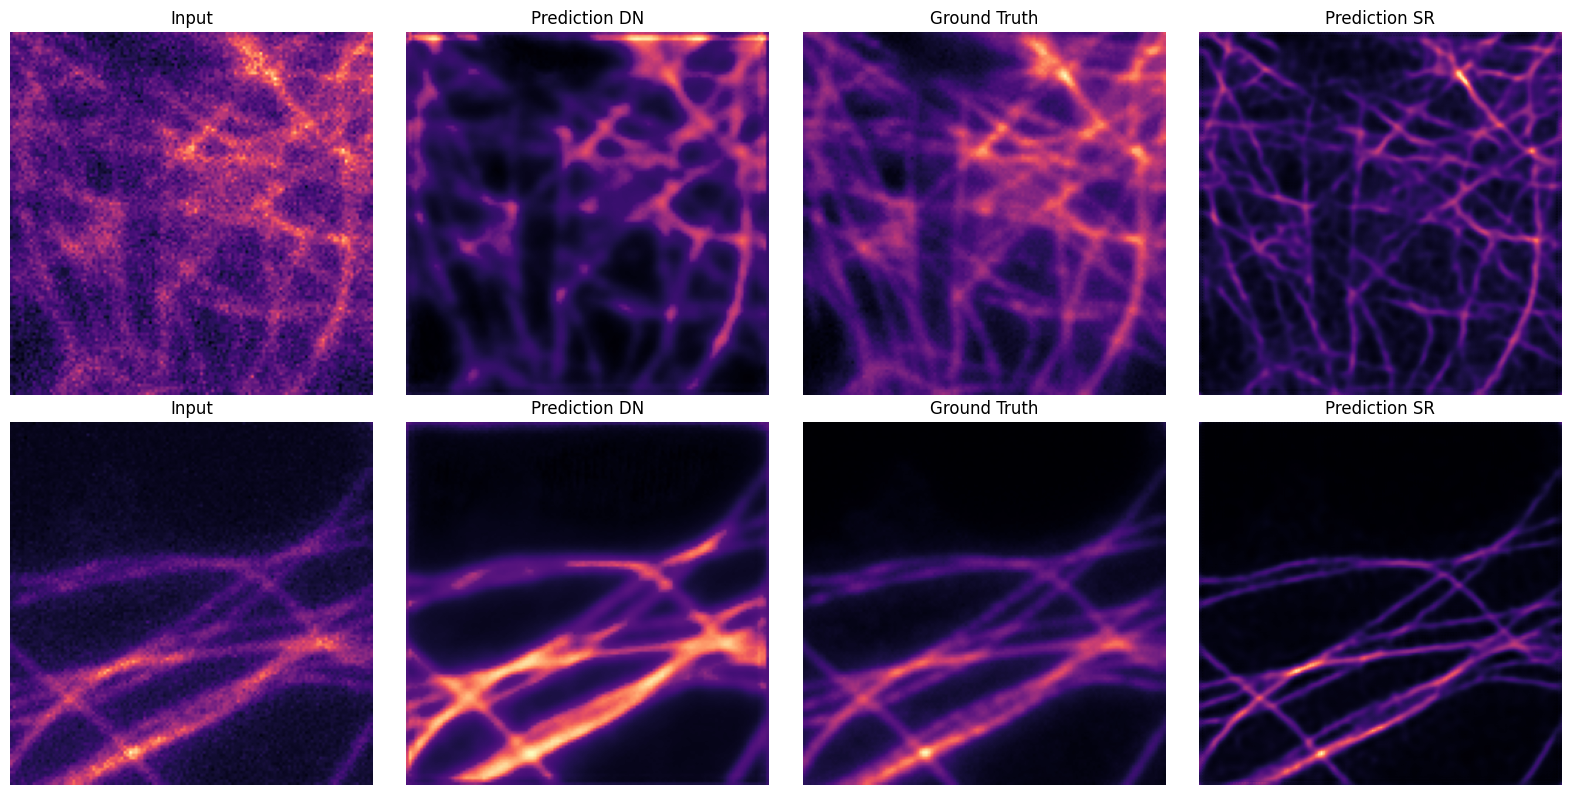

In [22]:
num_samples = input_val_plot.shape[0]//2
fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))

if num_samples == 1:
    axes = np.expand_dims(axes, axis=0)

titles = ['Input', 'Prediction DN', 'Ground Truth', 'Prediction SR']

for i in range(num_samples):
    # For each sample, plot the four images. If images have more than 2 dimensions, take the first channel.
    imgs = [
        input_val_plot[i],
        predictions_DN[i],
        Ground_truth_val_plot[i],
        predictions_SR[i]
    ]
    for j, img in enumerate(imgs):
        # If the image has a channel dimension, display the first channel
        if img.ndim > 2 and img.shape[-1] > 1:
            display_img = img[..., 0]
        else:
            display_img = np.squeeze(img)
        axes[i, j].imshow(display_img, cmap='magma')
        axes[i, j].set_title(titles[j])
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()